In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Evaluate performance of model trained with label bias

In [ ]:
exp_suffix = '3manu_pseudo0_c_30' #suffix for specific label bias experiment. i.e. 3manu_fuji_c_30, 3manu_gems_c_30, ...
alpha = 1.0

In [ ]:
prd_path = f'/vol/biomedic3/es525/mammo-label-bias/output-density-subject-labelbias/resnet18-b32-fixed-alpha-{alpha}-ffdm-lr-0.00001-binary-{exp_suffix}' #subject level
df_prd = pd.read_csv(os.path.join(prd_path, 'predictions.csv'))


In [ ]:
#get metadata for predictions
md = pd.read_csv(f'/vol/biomedic3/es525/mammo-label-bias/modified_metadata/labelbias_subjectlevel_{exp_suffix}.csv') # subject level
md['image_id'] = [img_path.split('/')[-1] for img_path in md.image_path.values]

/tmp/ipykernel_1731318/3769474196.py:2: DtypeWarning: Columns (31,32,51) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv(f'/vol/biomedic3/es525/mammo-net/modified_metadata/labelbias_subjectlevel_{exp_suffix}.csv') # subject level


In [27]:
df = pd.merge(df_prd, md, how='inner', on=['image_id'])
print(len(df))

38538


In [29]:
df['wrong_label'] = np.where(df['density_binary']!=df['biased_target'], 1, 0)

In [31]:
preds = np.stack([df['class_0'],df['class_1']]).transpose()
true_targets = np.array(df['density_binary'])
biased_targets = np.array(df['biased_target'])

In [32]:
true_fpr, true_tpr, true_thresh = roc_curve(true_targets, preds[:,1])
true_roc_auc = auc(true_fpr, true_tpr)

biased_fpr, biased_tpr, biased_thresh = roc_curve(biased_targets, preds[:,1])
biased_roc_auc = auc(biased_fpr, biased_tpr)

In [33]:
labels = np.argmax(preds, axis=1)
df['pred']=labels

### AUC on test set

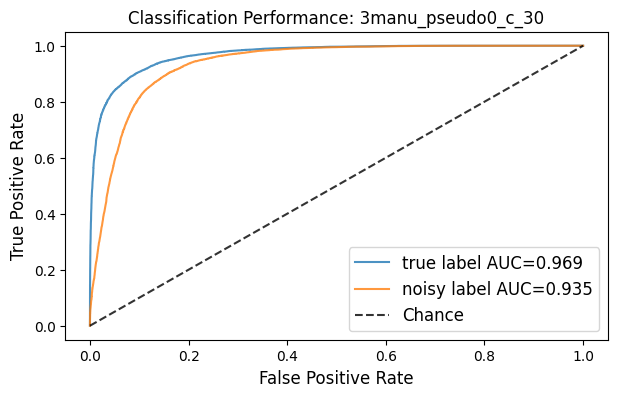

In [34]:
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(true_fpr, true_tpr, lw=1.5, alpha=.8, label='true label AUC=%0.3f' % true_roc_auc)
plt.plot(biased_fpr, biased_tpr, lw=1.5, alpha=.8, label='noisy label AUC=%0.3f' % biased_roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.title(f'Classification Performance: {exp_suffix}', fontsize=12)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
plt.show()

### find subgroup TPR for 10% overall FPR
* compute threshold for 10% FPR on validation set
* find test set subgroup performance

In [35]:
def tpr_at_fpr(fpr_value, fpr_arr, tpr_arr, thresh_arr):
    idx = (np.abs(fpr_arr - fpr_value)).argmin() #find index of closest calculated fpr to desired fpr value
    print(f'TPR @ {fpr_arr[idx]:.3f} FPR = {tpr_arr[idx]:.3f}, thresh = {thresh_arr[idx]:.3f} ')
    return thresh_arr[idx], fpr_arr[idx], tpr_arr[idx]

In [36]:
def subgroup_performance(df, category):
    for attribute in df[category].value_counts().index.tolist():
        df_s = df.loc[df[category]==attribute]

        n_tp = len(df_s.loc[df_s['TP']==1])
        n_fp = len(df_s.loc[df_s['FP']==1])
        n_tn = len(df_s.loc[df_s['TN']==1])
        n_fn = len(df_s.loc[df_s['FN']==1])

        tpr = n_tp/(n_tp+n_fn)
        fpr = n_fp/(n_fp+n_tn)

        print(f'tpr for {category}: {attribute} = {tpr*100:.1f}')
        print(f'fpr for {category}: {attribute} = {fpr*100:.1f}')
        print('-'*30)


In [37]:
# get validation set 
val_prd = pd.read_csv(os.path.join(prd_path, 'val_predictions.csv'))
df_val = pd.merge(val_prd, md, how='inner', on=['image_id'])
print(len(df_val))

31419


In [38]:
# find threshold for 10% fpr with both true and noisy labels on val set 
preds_val = np.stack([df_val['class_0'],df_val['class_1']]).transpose()
true_targets_val = np.array(df_val['density_binary'])
biased_targets_val = np.array(df_val['biased_target'])

true_fpr_val, true_tpr_val, true_thresh_val = roc_curve(true_targets_val, preds_val[:,1])
true_roc_auc_val = auc(true_fpr_val, true_tpr_val)

biased_fpr_val, biased_tpr_val, biased_thresh_val = roc_curve(biased_targets_val, preds_val[:,1])
biased_roc_auc_val = auc(biased_fpr_val, biased_tpr_val)

In [39]:
print('true labels:')
thresh_true, _, _, = tpr_at_fpr(0.1, true_fpr_val, true_tpr_val, true_thresh_val)
print(thresh_true)
print('noisy labels:')
thresh_noise, _, _, = tpr_at_fpr(0.1, biased_fpr_val, biased_tpr_val, biased_thresh_val)
print(thresh_noise)

true labels:
TPR @ 0.100 FPR = 0.921, thresh = 0.417 
0.41749415
noisy labels:
TPR @ 0.100 FPR = 0.840, thresh = 0.670 
0.66974485


In [ ]:
# --- pick either thresh_true or thresh_noise to compute performance at that threshold. comment out the other --- #

# optimal_threshold = thresh_true
optimal_threshold = thresh_noise

In [47]:
# get subgroup TPR/FPR at threshold
df['pred_opt'] = np.where(df['class_1']>=optimal_threshold, 1, 0)

df['TP'] = 0
df['FP'] = 0
df['TN'] = 0
df['FN'] = 0


df.loc[(df['pred_opt']==1) & (df['density_binary']==1), 'TP'] = 1
df.loc[(df['pred_opt']==1) & (df['density_binary']==0), 'FP'] = 1
df.loc[(df['pred_opt']==0) & (df['density_binary']==0), 'TN'] = 1
df.loc[(df['pred_opt']==0) & (df['density_binary']==1), 'FN'] = 1

In [48]:
# subgroup_performance(df, 'Manufacturer')
subgroup_performance(df, 'pseudo_subgroup')

tpr for pseudo_subgroup: 0 = 82.6
fpr for pseudo_subgroup: 0 = 4.2
------------------------------
tpr for pseudo_subgroup: 1 = 82.8
fpr for pseudo_subgroup: 1 = 4.5
------------------------------
tpr for pseudo_subgroup: 2 = 83.6
fpr for pseudo_subgroup: 2 = 4.8
------------------------------
